In [203]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import noisereduce as nr
import dataprocessing as dp
import librosa.feature as ft
from enum import Enum

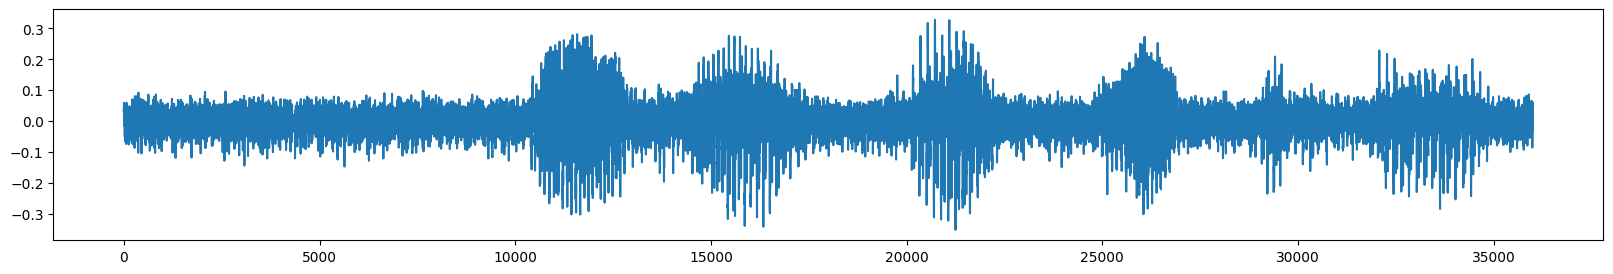

In [204]:
data, samplerate = sf.read('Y.wav')
seconds_to_plot = 1.5
indices_to_plot = int(seconds_to_plot * samplerate)
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(data[:indices_to_plot])
plt.show()

noise_seconds = 0.4
noise_indices = int(noise_seconds * samplerate)
noise_data = data[:noise_indices]
dp.resave('Y.wav', 0, noise_indices, 'Y_noise.wav')

E_noise_max=1.63e-03


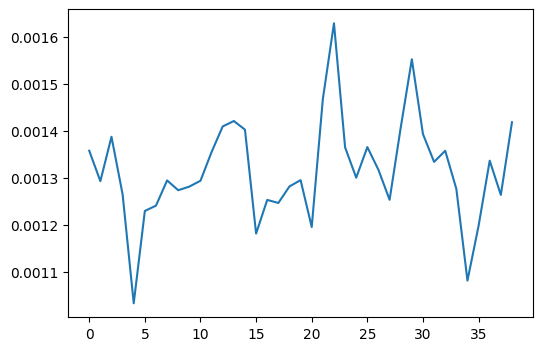

In [205]:
frame_time = 20e-3
frame_shift = 0.5


E = dp.dataToEnergy(noise_data, samplerate, frame_time, frame_shift, do_print=False)
E_noise_max = np.max(E)
print(f'{E_noise_max=:.2e}')
plt.rcParams["figure.figsize"] = (6,4)
plt.plot(E)
plt.show()

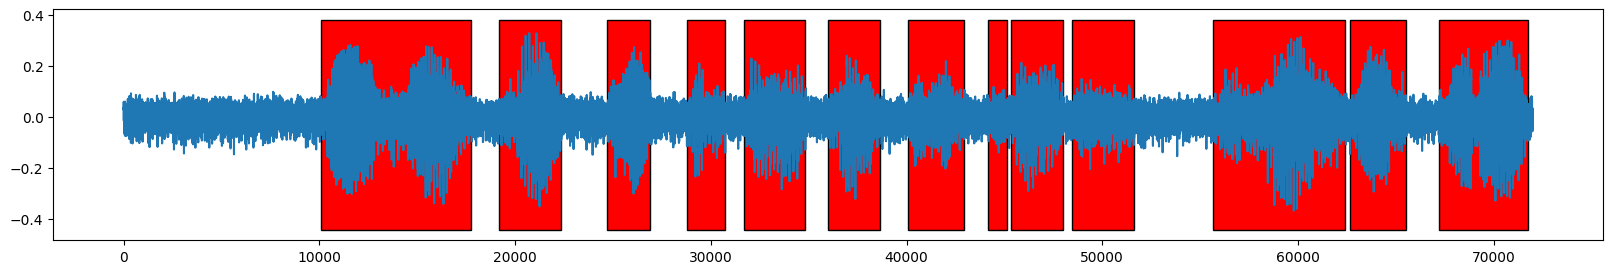

In [206]:
vadData, tickData = dp.VAD(data, samplerate, frame_time, frame_shift, noise_frame_end=0, eTh= E_noise_max)

seconds_to_plot = 3
indices_to_plot = int(seconds_to_plot * samplerate)
ticks = []
for tick in tickData:
    if tick > indices_to_plot:
        break

    ticks.append(tick)

plt.rcParams["figure.figsize"] = (20,3)
fig, ax = plt.subplots()
for i in range(int(len(ticks) / 2)):
    left_tick = ticks[2*i]
    right_tick = ticks[2*i + 1]
    rect = Rectangle((left_tick, np.min(data)), width=right_tick - left_tick, height = np.max(data) - np.min(data), facecolor='r', linewidth=1, edgecolor='k')
    ax.add_patch(rect)
    
ax.plot(data[:indices_to_plot])
plt.show()

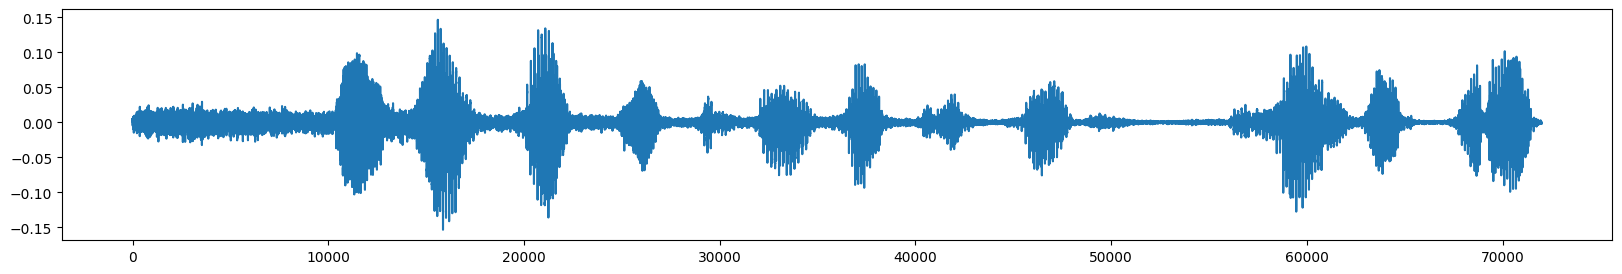

In [207]:
filtered_data = nr.reduce_noise(y=data, sr=samplerate, y_noise=noise_data, prop_decrease=1, thresh_n_mult_nonstationary=1.5, stationary=False)
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(filtered_data[:indices_to_plot])
plt.show()

sf.write('Y_filtered12.wav', filtered_data, samplerate)

In [208]:
def digital_filter(data, alpha):
    N = len(data)
    y = np.zeros(N)
    y[0] = data[0] / np.sqrt(1 - alpha**2)
    for n in range(1, N):
        y[n] = alpha * y[n-1] + np.sqrt(1 - alpha**2) * data[n]
    
    return y

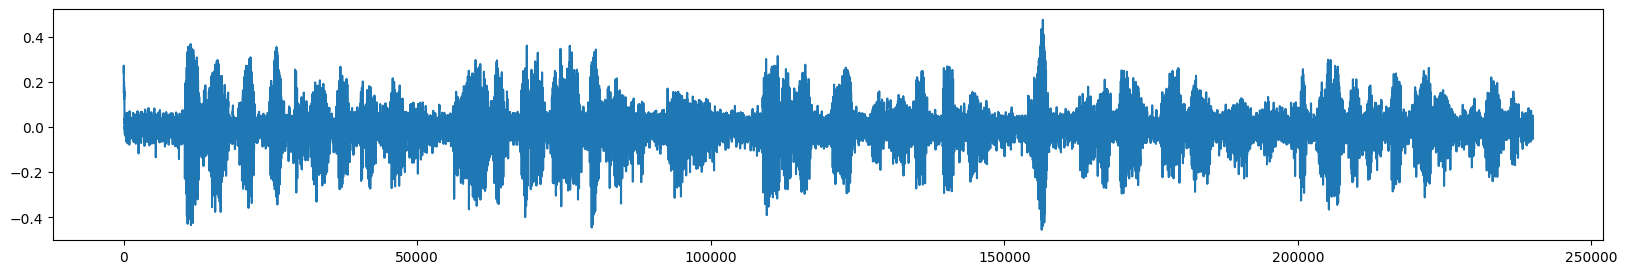

In [209]:
seconds_to_plot = 10
indices_to_plot = int(seconds_to_plot * samplerate)

filtered_data2 = digital_filter(data, 0.99)
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(filtered_data2[:indices_to_plot])
plt.show()

sf.write('Y_filtered2.wav', filtered_data2, samplerate)

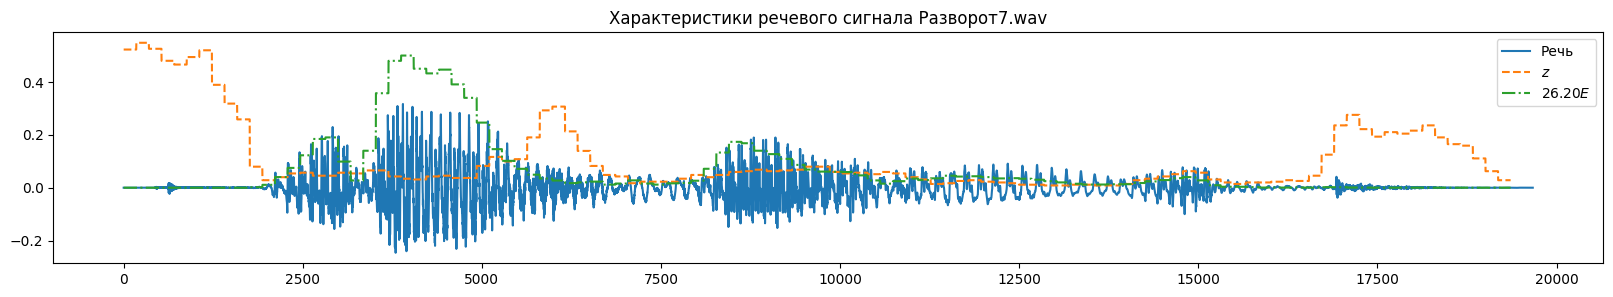

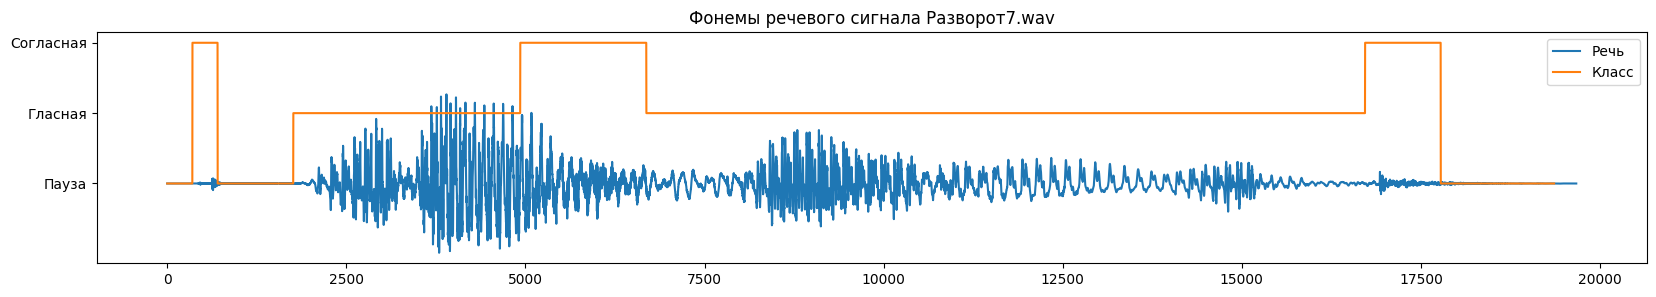

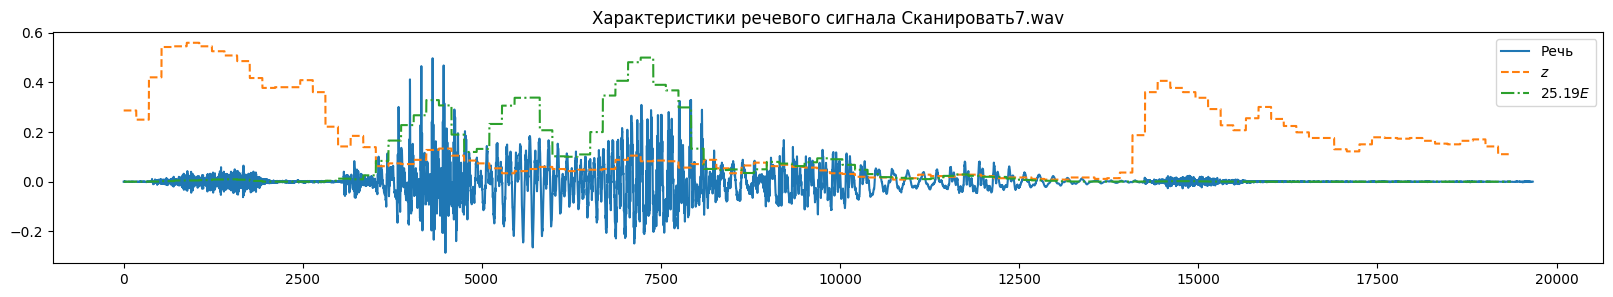

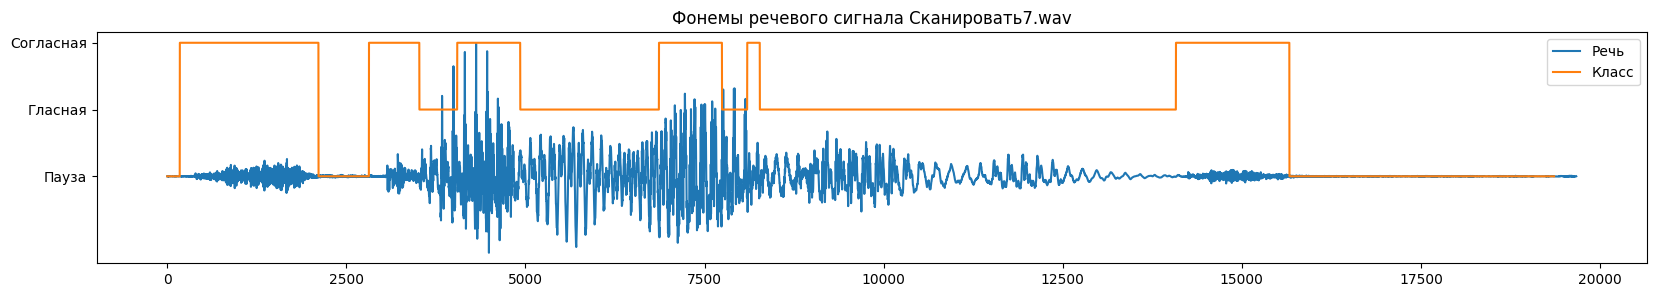

In [210]:
word1_path = './notebook/Разворот/Разворот7.wav'
word2_path = './notebook/Сканировать/Сканировать7.wav'

data1, samplerate1 = sf.read(word1_path)
data2, samplerate2 = sf.read(word2_path)

frame_time = 16e-3
frame_length = int(frame_time * samplerate1)
frame_shift_ratio = 0.5
frame_shift = int(frame_shift_ratio * frame_length)

class Phoneme(Enum):
    Pause = 0
    Vowel = 1
    Consonant = 2

    def __int__(self):
        return self.value

def scale_to_plot(data):
    to_plot_data = []
    for zero_crossing_rate in data:
        to_plot_data += [zero_crossing_rate] * frame_shift
    
    return to_plot_data

def calc_plot_features(data, samplerate, frame_length, frame_shift, E_max, z_max, data_name:str = ''):
    E = dp.dataToEnergy(data, samplerate, frame_time, frame_shift_ratio, do_print=False)
    E = np.array(E)
    E_max_calc = np.max(E)
    scaler = 0.5/E_max_calc
    E *= scaler
    zero_crossing_rates = ft.zero_crossing_rate(data, frame_length=frame_length, hop_length=frame_shift, center=False)

    phoneme_classes = np.empty(len(E), dtype=object)
    # 1. Маски
    pause_mask = E < E_max
    vowel_mask = (~pause_mask) & (zero_crossing_rates[0] < z_max)
    consonant_mask = ~(pause_mask | vowel_mask)

    # 2. Запись классов по маскам
    phoneme_classes[pause_mask] = Phoneme.Pause
    phoneme_classes[vowel_mask] = Phoneme.Vowel
    phoneme_classes[consonant_mask] = Phoneme.Consonant

    to_plot_crossing_rate = scale_to_plot(zero_crossing_rates.flatten())
    to_plot_E = scale_to_plot(E)
    to_plot_classes = scale_to_plot(phoneme_classes)

    plt.title(f'Характеристики речевого сигнала {data_name}')
    plt.plot(data, label='Речь')
    plt.plot(to_plot_crossing_rate, '--', label='$z$')
    plt.plot(to_plot_E, '-.', label=f'${scaler:.2f}E$')
    plt.legend()
    plt.show()
    
    plt.title(f'Фонемы речевого сигнала {data_name}')
    plt.plot(data, label='Речь')
    plt.plot(0.25*np.int16(to_plot_classes), label='Класс')
    plt.yticks(
        [0, 0.25, 0.5], 
        ['Пауза', 'Гласная', 'Согласная']
    )
    plt.legend()
    plt.show()

    return E, zero_crossing_rates

E_max = 1e-4
z_max = 0.08

calc_plot_features(data1, samplerate1, frame_length, frame_shift, E_max, z_max, word1_path.split('/')[-1])
calc_plot_features(data2, samplerate2, frame_length, frame_shift, E_max, z_max, word2_path.split('/')[-1])
pass